# Analysis of Effects of Quality Pitching vs. Quality Batting on the Success of MLB Teams in the Post-Integration League

#### Author: Andrew Bachman
#### UID: 115 895 836
#### Final Tutorial - CMSC 320

This jupyter notebook is for the Final Tutorial assignment for CMSC 320 at the University of Maryland, College Park. 

In [1]:
# necessary imports

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV

# literally just to make a range later
from itertools import chain

# Introduction

Baseball has become an incredibly data driven sport in recent times. Sabermetrics, a term for ["the search for objective knowledge about baseball," coined by Bill James](https://sabr.org/sabermetrics) began this revolutionizing of the way the game was looked at in the 1980s. Since then, we have seen this approach reach the uppermost level of baseball competition: MLB. 

The most famous example of this manifestation was the 2002 Oakland A's (perhaps you have heard of [Moneyball...](https://en.wikipedia.org/wiki/Moneyball_(film))), who based thier approach to assembling a team under heavy financial constraints on statistics instead of subjective scout evaluation. Today we see teams like the Los Angeles Dodgers and the Tampa Bay Rays taking very analytically driven approaches to thier teams and decisions, and having impressive success, and outdoing the Moneyball A's in terms of monetarily constrained success in the case of the latter.


# Data Science & Baseball

As mentioned above, statistics, analysis, and data science have made themselves a central part of baseball in the past few decades. Models that can predict and analyze results are extraordinarily useful to the front offices of MLB teams when they are trying to piece together a winning team.

This project will investigate the correlations between team batting and pitching statistics and team success, and develop a model to attempt to predict team success based on those statistics. We will utilize SciKit Learn's linear and logistic regression features to accomplish this. 

# Gathering and Processing the data

First we have to obtain the data we intend to examine. For this project, we will be using [Lahman's Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/), an SQLite database and query the necessary data about pitching and batting. We will first extract basic statistics and counts *per team*, like hits, homeruns, strikeouts, innnings pitched, etc. We will be focusing on data post-integration (1947).

After we query the SQLite table, some cleaning of the data needs to be done. Since the stats for intentional walks (IBB) and sacrifice flies (SF) were not always tracked, we have to replace those missing values in the data with something, and in this case I have chosen zero. We can accomplish this using pandas' fillna() function on the respective columns of the dataframe.

#### NOTE: You would need to download Lahman's database and later the csv files from BBRef (they are not large) to recreate these results. The necessary links are given. You will need to place these files in the directory that you are running this notebook from, as well as either renaming them to match the names I used, or changing the target file name in the code where necessary.

In [2]:
# connect to SQL file
sqlite_file = 'lahmansbaseballdb.sqlite'
conn = sqlite3.connect(sqlite_file)

# query to get stats from the batting table
batting_query = "SELECT yearID, teamID, team_ID, sum(AB) as AB, sum(R) as R, sum(H) as H, sum(HR) as HR, sum(RBI) as RBI, sum(BB) as BB, sum(SO) as K, sum(IBB) as IBB, sum(HBP) as HBP, sum(SF) as SF FROM batting GROUP BY team_ID, yearID"
batting = pd.read_sql(batting_query, conn)

# We will only be looking at post integration data, so we can discard years before 1947
batting = batting[batting.yearID >= 1947]

# these stats were not tracked for some of the earlier years, so we will fill the missing values 
# with zeros
batting['IBB'].fillna(0, inplace=True)
batting['SF'].fillna(0, inplace=True)

Since the batting table holds statistics for *players*, we need to calculate some of the team statistics. The SQL query above specifies to calculate the sum of the columns per team for counting stats like hits and homeruns. 

Additionally, we will be calculating the team [batting average](https://www.baseball-reference.com/leaders/batting_avg_career.shtml) (team_avg) and the team [on-base percentage](https://www.baseball-reference.com/leaders/onbase_perc_career.shtml) (team_OBP). Once we have these statistics, the columns AB and H can be dropped, as they wont be used later (the raw numbers are not needed once we have the batting average they describe).

The formulas for batting average and on base percentage are given below, respectively:

<h1><center>$\textrm{avg} = \frac{\textrm{total hits}}{\textrm{total at-bats}}$</center></h1>

<h1><center>$\textrm{OBP} = \frac{\textrm{H } + \textrm{ BB } + \textrm{ IBB } + \textrm{ HBP}}{\textrm{AB } +\textrm{ H } + \textrm{ BB } + \textrm{ IBB } + \textrm{ HBP } + \textrm{ SF}}$</center></h1>

We calculate these values by inserting two new columns to hold the values, then iterating over every row of the dataframe and calculating avg and OBP using the values of the comprising statistics in each row. 

In [3]:
# create a column for team batting average (H / AB)
batting.insert(13, 'team_avg', 0.0)
for row in batting.iterrows():
    batting.at[row[0], 'team_avg'] = round((batting.at[row[0], 'H'] / batting.at[row[0], 'AB']), 3)
    
# create a column for team on base percentage (H + BB (+ IBB) + HBP) / (AB + BB (+ IBB) + HBP + SF)
batting.insert(14, 'team_OBP', 0.0)
for row in batting.iterrows():
    on_base = (batting.at[row[0], 'H'] + batting.at[row[0], 'BB'] + batting.at[row[0], 'IBB'] + batting.at[row[0], 'HBP'])
    plate_apps = (batting.at[row[0], 'AB'] + batting.at[row[0], 'BB'] + batting.at[row[0], 'IBB']  + batting.at[row[0], 'HBP'] + batting.at[row[0], 'SF'])
    
    batting.at[row[0], 'team_OBP'] = round((on_base / plate_apps), 3)
    
batting.drop('AB', axis=1, inplace=True)
batting.drop('H', axis=1, inplace=True)
#batting.drop('R', axis=1, inplace=True)

batting.tail()

,yearID,teamID,team_ID,R,HR,RBI,BB,K,IBB,HBP,SF,team_avg,team_OBP
2920,2019,SLN,2921,764,210,714.0,561,1420.0,15.0,76.0,39.0,0.245,0.324
2921,2019,TBA,2922,769,217,730.0,542,1493.0,20.0,73.0,34.0,0.254,0.327
2922,2019,TEX,2923,810,223,765.0,534,1578.0,18.0,67.0,44.0,0.248,0.321
2923,2019,TOR,2924,726,247,697.0,509,1514.0,10.0,45.0,28.0,0.236,0.306
2924,2019,WAS,2925,873,231,824.0,584,1308.0,33.0,81.0,42.0,0.265,0.345


Now we are going to make a similar query to the pitching table in the SQLite database, and cut off years before 1947 again. 

In [4]:
pitching_query = "SELECT yearID, teamID, team_ID, sum(W) as W, sum(L) as L, sum(CG) as CG, sum(SHO) as CGSO, sum(IPouts) as IP, sum(H) as H, sum(ER) as ER, sum(HR) as HR, sum(BB) as BB, sum(SO) as K, avg(BAOpp) as BAA, sum(GIDP) as GIDP FROM pitching GROUP BY team_ID, yearID"

pitching = pd.read_sql(pitching_query, conn)
pitching = pitching[pitching.yearID >= 1947]

The pitching table also features numbers on a by-player basis, so some need to be summed or averaged, as above. 

We will also calculate the [earned run average](https://www.baseball-reference.com/leaders/earned_run_avg_career.shtml), which is a statistic that shows how many runs per nine innings (length of a standard baseball game) that the pitching staff of a team has given up on average, and is generally used as an indicator of the quality of a pitcher or entire staff. Lastly we calculate WHIP [(Walks and Hits per Inning Pitched)](http://m.mlb.com/glossary/standard-stats/walks-and-hits-per-inning-pitched#:~:text=WHIP%20is%20one%20of%20the,by%20his%20total%20innings%20pitched.), which is a statistic that measures how many baserunners per inning a pitcher allows. The lower the WHIP, the better.

Once again these formulas are given here, respectively:

<h1><center>$\textrm{ERA} = \frac{\textrm{total earned runs}}{\textrm{total innings pitched}}$</center></h1>

<h1><center>$\textrm{WHIP} = \frac{\textrm{H } + \textrm{ BB }}{\textrm{IP}}$</center></h1>

We calculate these using the same method as avg and OBP from above, but of course using the different formulas and values. We also fill missing values in the GIDP column with zeros.

In [5]:
pitching.insert(15, 'ERA', 0.0)
pitching.IP = pitching.IP.astype(float)

pitching.insert(16, 'WHIP', 0.0)
pitching.IP = pitching.IP.astype(float)

for row in pitching.iterrows():
    pitching.at[row[0], 'IP'] =  round((pitching.at[row[0], 'IP'] / 3), 2)
    pitching.at[row[0], 'ERA'] = round((9 * pitching.at[row[0], 'ER'] / pitching.at[row[0], 'IP']), 2)
    
    pitching.at[row[0], 'WHIP'] = round(((pitching.at[row[0], 'H'] + pitching.at[row[0], 'BB']) / pitching.at[row[0], 'IP']), 2)
    
    

pitching['GIDP'].fillna(0.0, inplace=True)


pitching.tail()

,yearID,teamID,team_ID,W,L,CG,CGSO,IP,H,ER,HR,BB,K,BAA,GIDP,ERA,WHIP
2920,2019,SLN,2921,91,71,1,1,1444.00,1284,613,191,545,1399,0.238478,139.0,3.82,1.27
2921,2019,TBA,2922,96,66,0,0,1474.33,1274,602,181,453,1621,0.242667,107.0,3.67,1.17
2922,2019,TEX,2923,78,84,4,1,1438.00,1515,813,241,583,1379,0.286917,131.0,5.09,1.46
2923,2019,TOR,2924,67,95,1,0,1440.33,1450,767,228,604,1332,0.279256,111.0,4.79,1.43
2924,2019,WAS,2925,93,69,1,1,1439.33,1340,684,202,517,1511,0.323774,98.0,4.28,1.29


Since the batting table did not contain a column for wins, we will add those using the data from the pitching table. This works with no modification because the tables are of the same length since they store the same set of teams' data.

In [6]:
batting.insert(13, 'W', 0)
batting.W = pitching.W.values
batting.tail()

,yearID,teamID,team_ID,R,HR,RBI,BB,K,IBB,HBP,SF,team_avg,team_OBP,W
2920,2019,SLN,2921,764,210,714.0,561,1420.0,15.0,76.0,39.0,0.245,0.324,91
2921,2019,TBA,2922,769,217,730.0,542,1493.0,20.0,73.0,34.0,0.254,0.327,96
2922,2019,TEX,2923,810,223,765.0,534,1578.0,18.0,67.0,44.0,0.248,0.321,78
2923,2019,TOR,2924,726,247,697.0,509,1514.0,10.0,45.0,28.0,0.236,0.306,67
2924,2019,WAS,2925,873,231,824.0,584,1308.0,33.0,81.0,42.0,0.265,0.345,93


Lastly for data collection and processing, we will gather data from the teams table of the database which outlines the teams' success in any given year. In particular we are obtaining the wins, losses, the teams' finishing place in their divisions, if the team won thier league, and if the team won the World Series that year. League wins, World Series wins, and division place are data that are consistently tracked since integration, making them useful for us. 

Below we query the teams table for the data described above, then convert the LgWin and WSWin columns to booleans, and then turn the teamRank column into a boolean column describing if the team finished in the top two in thier respective division. We will consider a top-two finish a success for this project, as the early rounds of the playoffs we have in the modern MLB Postseason (Wildcard, Division Series, and League Championship Series) were not always present, and are missing from data in this table prior to thier introduction. 

In [7]:
success_query = "SELECT ID, yearID, teamID, W, L, teamRank, LgWin, WSWin FROM teams"

success = pd.read_sql(success_query, conn)
success = success[success.yearID >= 1947]
success['LgWin'] = success['LgWin'].apply(lambda x: x == 'Y')
success['WSWin'] = success['WSWin'].apply(lambda x: x == 'Y')
success['teamRank'] = success['teamRank'].apply(lambda x: x <= 2)
success.tail()

,ID,yearID,teamID,W,L,teamRank,LgWin,WSWin
2920,2921,2019,SLN,91,71,True,False,False
2921,2922,2019,TBA,96,66,True,False,False
2922,2923,2019,TEX,78,84,False,False,False
2923,2924,2019,TOR,67,95,False,False,False
2924,2925,2019,WAS,93,69,True,True,True


Now that we have this success data, we can merge it's dataframe with the pitching and batting dataframes, once again with no modification since they share indexing. This makes the data more easily accessible when trying to model and predict success later.

In [8]:
pitching = pitching.merge(success)
pitching.tail()

,yearID,teamID,team_ID,W,L,CG,CGSO,IP,H,ER,...,BB,K,BAA,GIDP,ERA,WHIP,ID,teamRank,LgWin,WSWin
1775,2019,SLN,2921,91,71,1,1,1444.00,1284,613,...,545,1399,0.238478,139.0,3.82,1.27,2921,True,False,False
1776,2019,TBA,2922,96,66,0,0,1474.33,1274,602,...,453,1621,0.242667,107.0,3.67,1.17,2922,True,False,False
1777,2019,TEX,2923,78,84,4,1,1438.00,1515,813,...,583,1379,0.286917,131.0,5.09,1.46,2923,False,False,False
1778,2019,TOR,2924,67,95,1,0,1440.33,1450,767,...,604,1332,0.279256,111.0,4.79,1.43,2924,False,False,False
1779,2019,WAS,2925,93,69,1,1,1439.33,1340,684,...,517,1511,0.323774,98.0,4.28,1.29,2925,True,True,True


In [9]:
batting = batting.merge(success)
batting.tail()

,yearID,teamID,team_ID,R,HR,RBI,BB,K,IBB,HBP,SF,team_avg,team_OBP,W,ID,L,teamRank,LgWin,WSWin
1780,2019,SLN,2921,764,210,714.0,561,1420.0,15.0,76.0,39.0,0.245,0.324,91,2921,71,True,False,False
1781,2019,TBA,2922,769,217,730.0,542,1493.0,20.0,73.0,34.0,0.254,0.327,96,2922,66,True,False,False
1782,2019,TEX,2923,810,223,765.0,534,1578.0,18.0,67.0,44.0,0.248,0.321,78,2923,84,False,False,False
1783,2019,TOR,2924,726,247,697.0,509,1514.0,10.0,45.0,28.0,0.236,0.306,67,2924,95,False,False,False
1784,2019,WAS,2925,873,231,824.0,584,1308.0,33.0,81.0,42.0,0.265,0.345,93,2925,69,True,True,True


# Data Visualization 

Now we are going to plot the data to get a general sense of what is going on with it, and to see if we can spot any trends or correlations. 

### Batting

First, we are going to look at on base percentage versus wins using matplotlib. We visualize this data with a scatterplot. 

(array([ 30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120.]),
 <a list of 10 Text major ticklabel objects>)

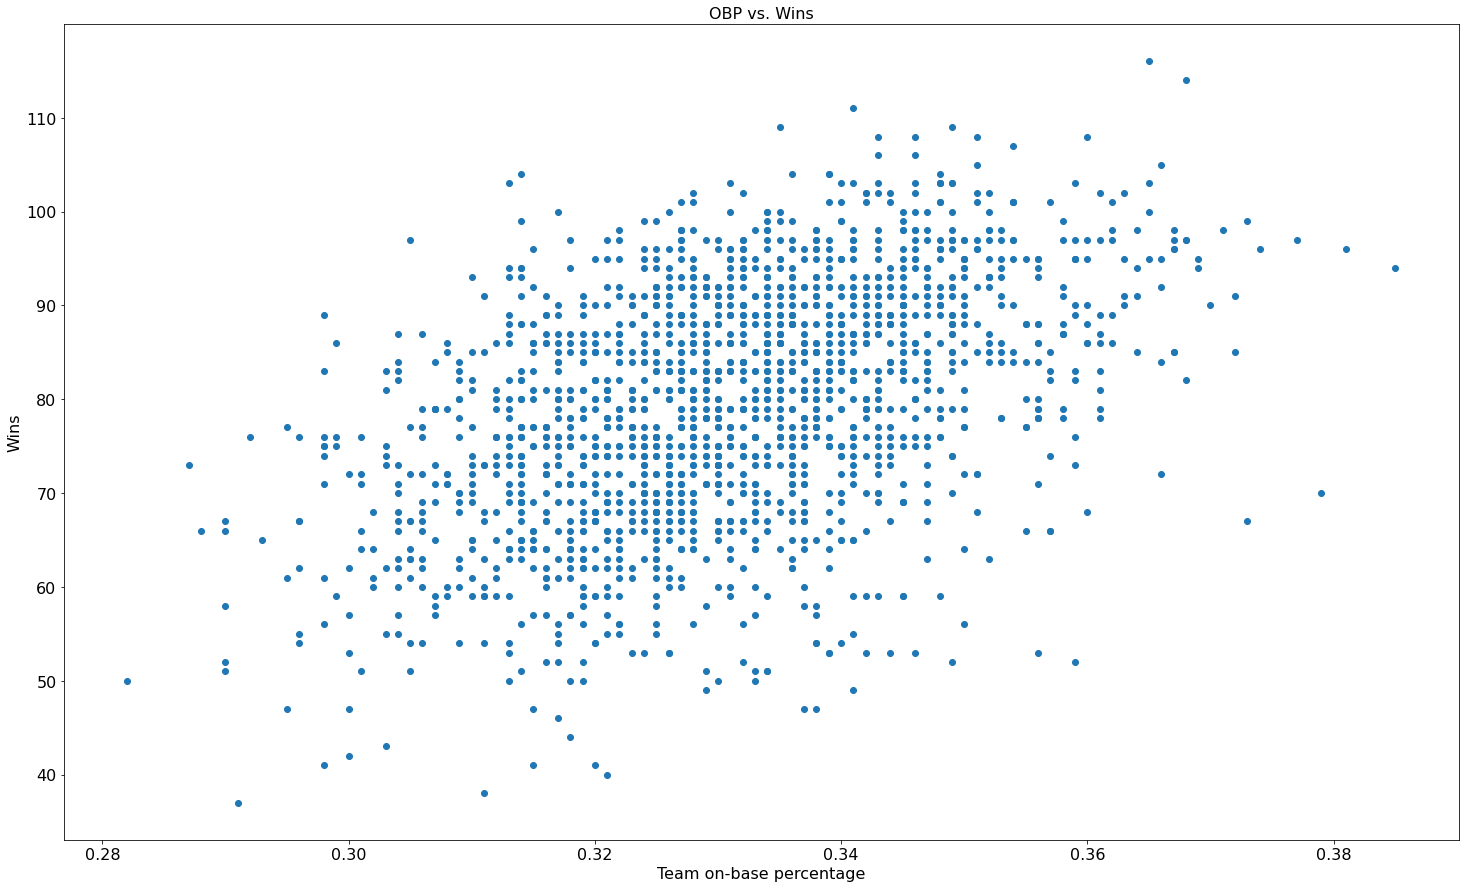

In [10]:
fig, ax = plt.subplots(figsize=(25, 15))
plt.scatter(batting.team_OBP, batting.W)
plt.xlabel("Team on-base percentage", size=16)
plt.ylabel("Wins", size=16)
plt.title("OBP vs. Wins", size=16)
plt.xticks(size=16)
plt.yticks(size=16)

This plot shows that there is a lot of variance here, but also shows an overall trend of teams with higher on- base percentages winning more games. The graph does suggest that wins and on base percentage may share a somewhat linear relationship. Next we will look at the same thing for batting average:

(array([ 30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120.]),
 <a list of 10 Text major ticklabel objects>)

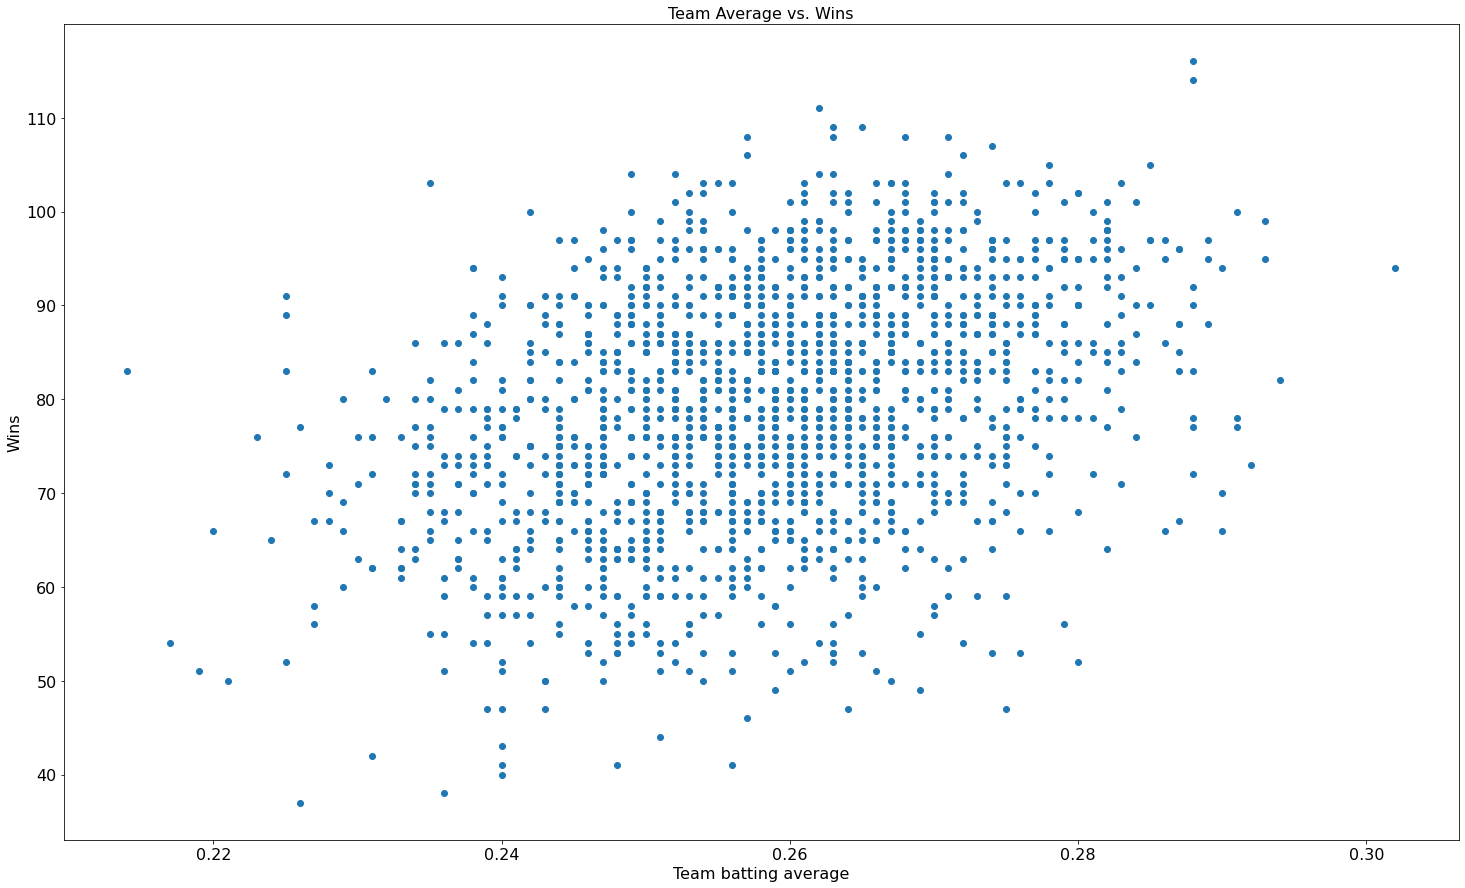

In [11]:
fig, ax = plt.subplots(figsize=(25, 15))
plt.scatter(batting.team_avg, batting.W)
plt.xlabel("Team batting average", size=16)
plt.ylabel("Wins", size=16)
plt.title("Team Average vs. Wins", size=16)
plt.xticks(size=16)
plt.yticks(size=16)

This plot is very similar to the above plot, which makes sense since OBP also takes hits into account. This plot also hints at a possibly linear (but less so than OBP) relationship between batting average and wins. 

Next is a plot showing the difference in average OBP's between teams that placed top two in their divisions versus teams that did not.

(array([0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 ]),
 <a list of 7 Text major ticklabel objects>)

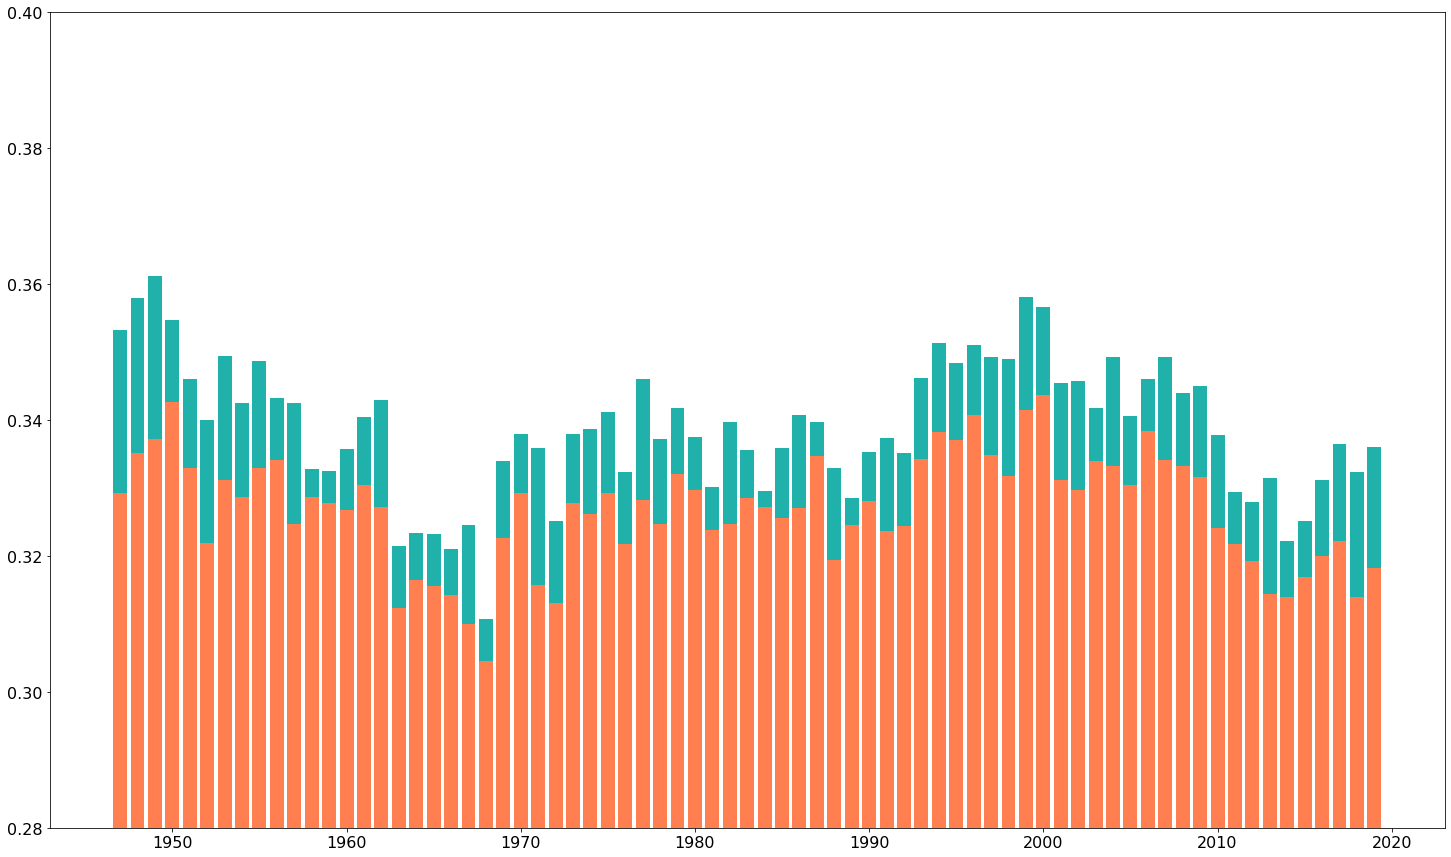

In [12]:
winners = batting[batting.teamRank == True]
losers = batting[batting.teamRank != True]
fig, ax = plt.subplots(figsize=(25, 15))

win_groups = winners.groupby(winners.yearID)
win_values = []
for name, group in win_groups:
    win_values.append((name, group.team_OBP.mean()))

years, mean_OBP = zip(*win_values)
plt.bar(years, mean_OBP, color='lightseagreen')


L_groups = losers.groupby(losers.yearID)
L_values = []
for name, group in L_groups:
    L_values.append((name, group.team_OBP.mean()))

years, mean_OBP = zip(*L_values)
plt.bar(years, mean_OBP, color='coral')

plt.ylim(.28, .4)
plt.xticks(size=16)
plt.yticks(size=16)

This plot shows that the teams who placed top-two in their division (in blue) had a higher on base percentage than teams that finished lower (in orange). This shows that for sure there is some form of relationship between on base percentage and winning. 

### Pitching

Now we are going to create some similar plots, but using pitching statistics. 

First I will plot ERA, BAA, and WHIP against wins, in that order:

(array([ 30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120.]),
 <a list of 10 Text major ticklabel objects>)

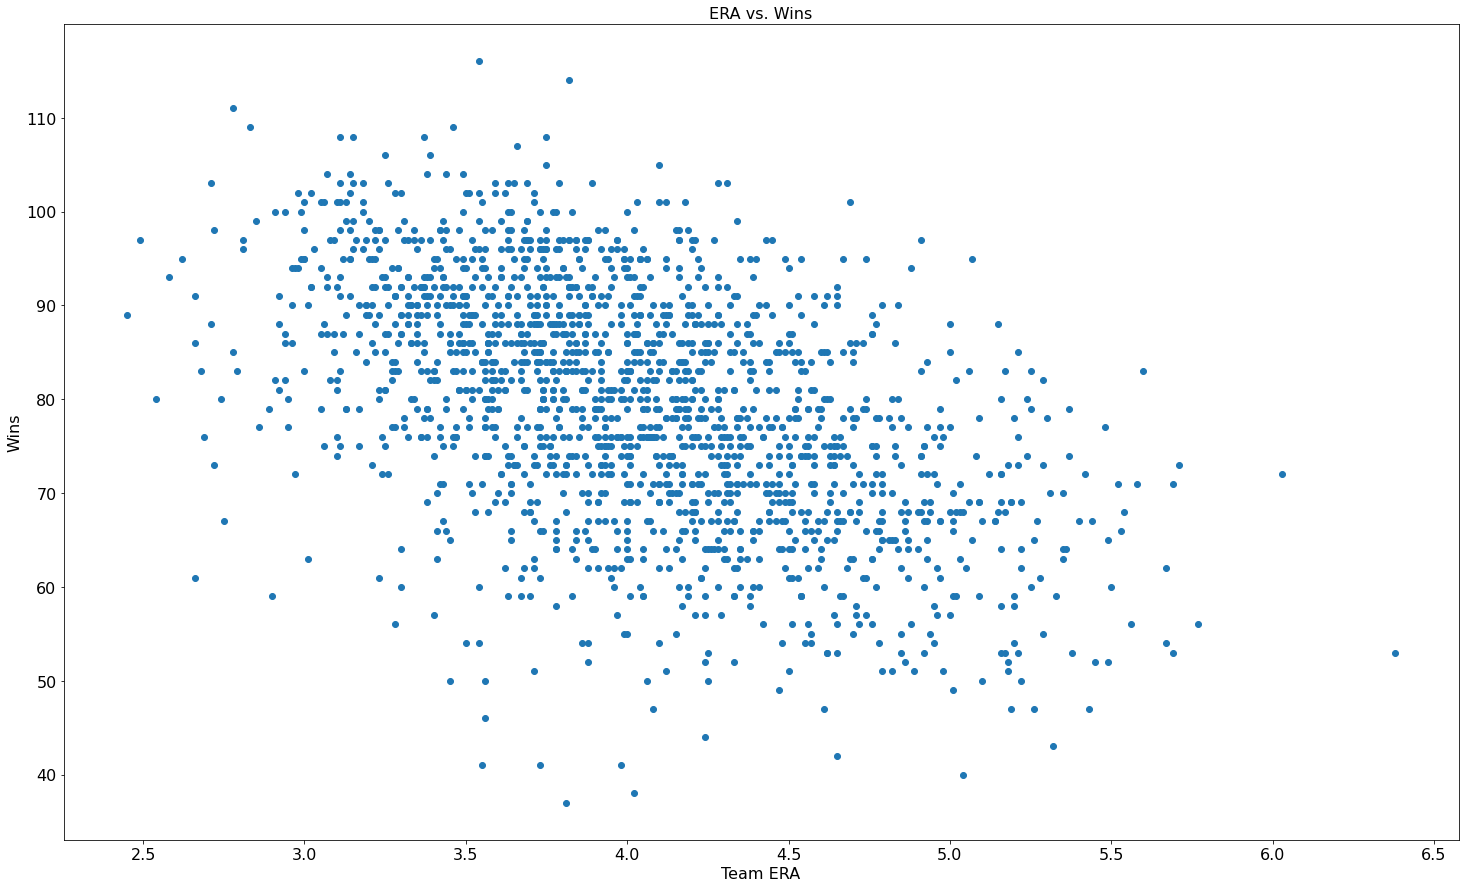

In [13]:
fig, ax = plt.subplots(figsize=(25, 15))
plt.scatter(pitching.ERA, pitching.W)
plt.xlabel("Team ERA", size=16)
plt.ylabel("Wins", size=16)
plt.title("ERA vs. Wins", size=16)
plt.xticks(size=16)
plt.yticks(size=16)

The graph here is slanted in the opposite way as the batting ones, but it makes sense that it is. Teams with lower overall ERA's should allow less runs, in turn giving them more wins, or at least more chance to win. The plot shows a trend and possible linear relationship between lower ERAs and wins. 

Moving on to batting average against:

(array([ 30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120.]),
 <a list of 10 Text major ticklabel objects>)

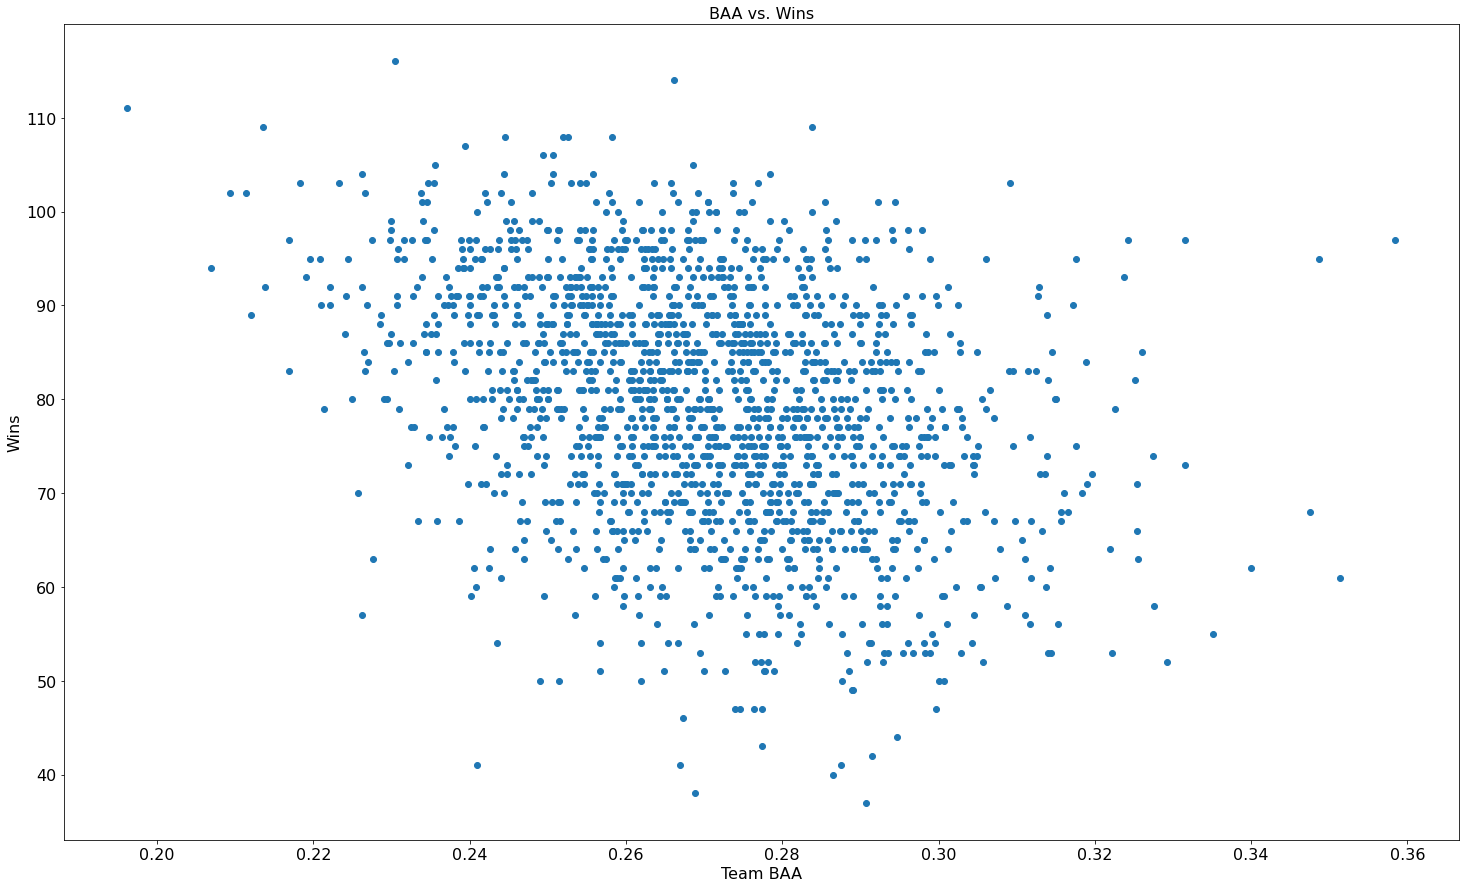

In [14]:
fig, ax = plt.subplots(figsize=(25, 15))
plt.scatter(pitching.BAA, pitching.W)
plt.xlabel("Team BAA", size=16)
plt.ylabel("Wins", size=16)
plt.title("BAA vs. Wins", size=16)
plt.xticks(size=16)
plt.yticks(size=16)

This graph of Batting Average Against versus wins is a little more confusing. There could be some underlying convoluting variables here, such as that some pitching may give up more hits, but still be effective in terms of giving up few runs and winning games (i.e, a strikeout pitcher (like for example, [Max Scherzer](https://www.baseball-reference.com/players/s/scherma01.shtml), is less likely to give up hits but may give up more damaging hits like HRs and extra base hits, while a ground/fly ball pitcher is more likely to give up hits because they allow more contact, like [Dallas Keuchel](https://www.baseball-reference.com/players/k/keuchda01.shtml)).

Finally we graph team WHIP versus wins:

(array([ 30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120.]),
 <a list of 10 Text major ticklabel objects>)

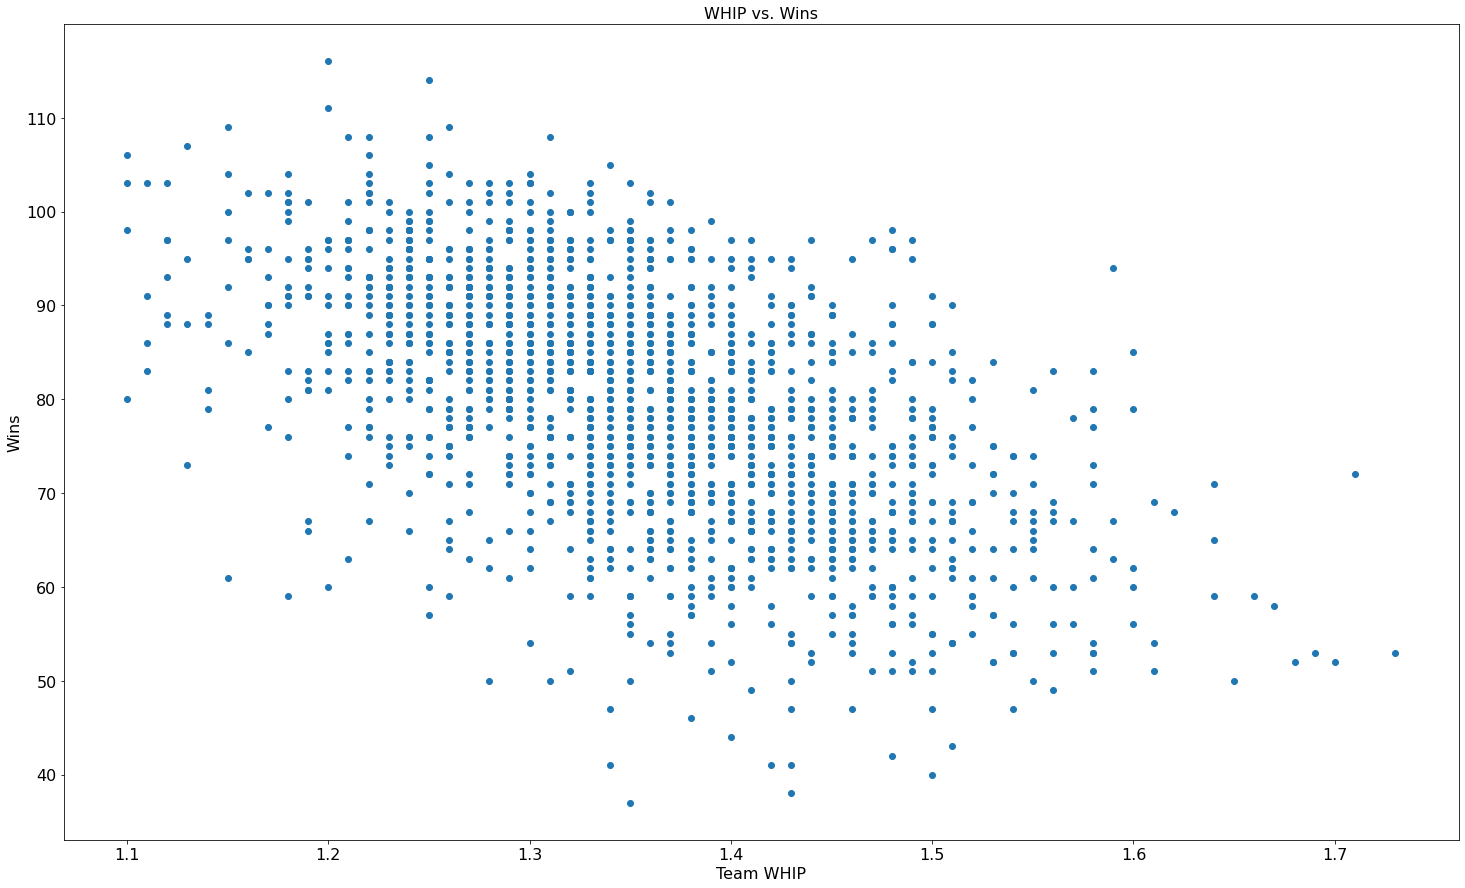

In [15]:
fig, ax = plt.subplots(figsize=(25, 15))
plt.scatter(pitching.WHIP, pitching.W)
plt.xlabel("Team WHIP", size=16)
plt.ylabel("Wins", size=16)
plt.title("WHIP vs. Wins", size=16)
plt.xticks(size=16)
plt.yticks(size=16)

This plot is super similar to the ERA plot, showing a similar relationship between lower WHIPs and higher win totals, once again suggesting that there is likely some form of linear relationship between WHIP and wins. 


Now we will create some plots similar to the success comparison ones from the batting data. First we plot the ERAs of successful teams versus those of non successful teams. 

(array([0., 1., 2., 3., 4., 5., 6.]),
 <a list of 7 Text major ticklabel objects>)

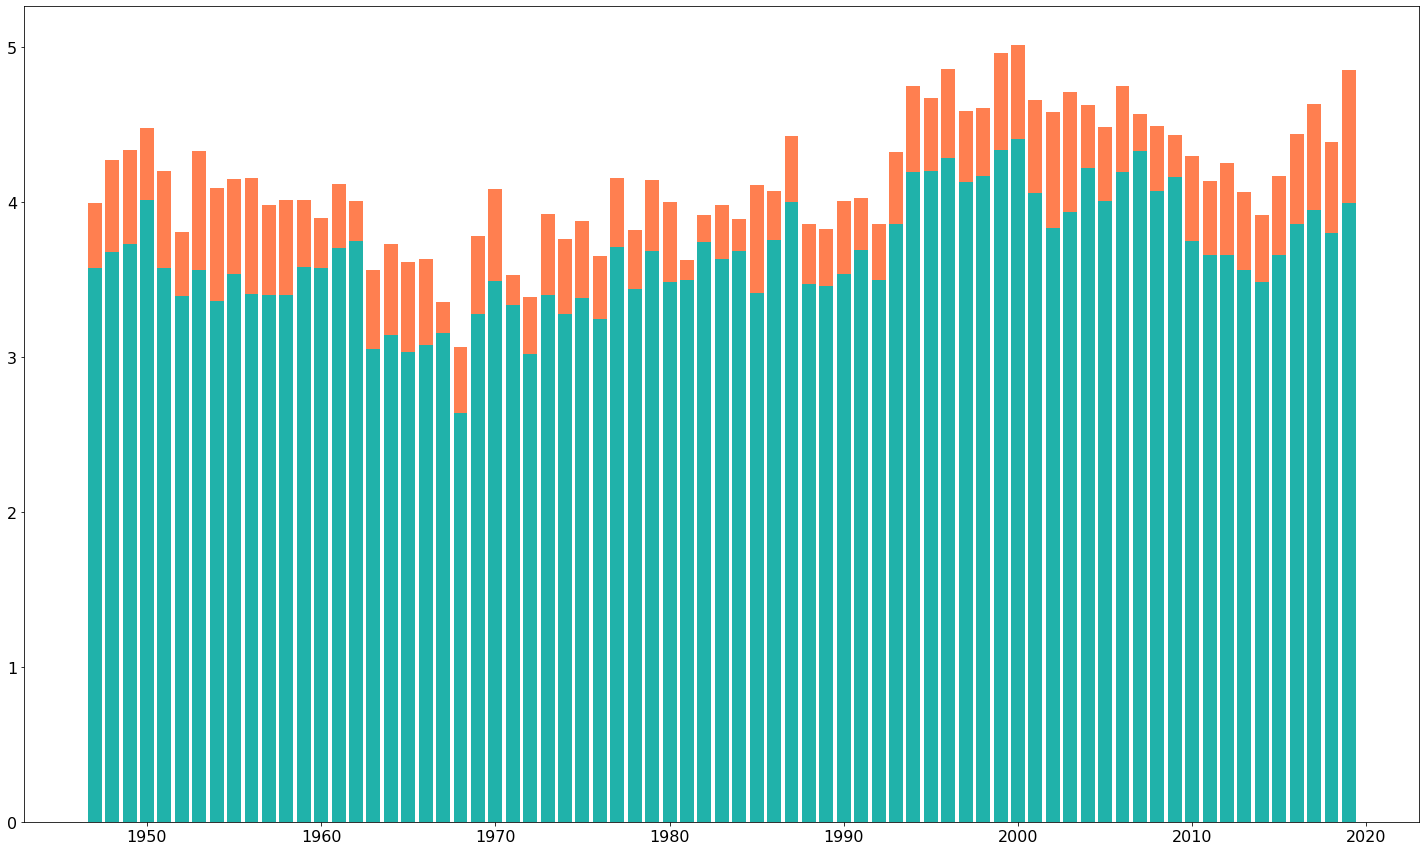

In [16]:
winners = pitching[pitching.teamRank == True]
losers = pitching[pitching.teamRank != True]
fig, ax = plt.subplots(figsize=(25, 15))

L_groups = losers.groupby(losers.yearID)
L_values = []
for name, group in L_groups:
    L_values.append((name, group.ERA.mean()))

L_years, L_mean_ERA = zip(*L_values)
plt.bar(L_years, L_mean_ERA, color='coral')

win_groups = winners.groupby(winners.yearID)
win_values = []
for name, group in win_groups:
    win_values.append((name, group.ERA.mean()))

W_years, W_mean_ERA = zip(*win_values)
plt.bar(W_years, W_mean_ERA, color='lightseagreen')
plt.xticks(size=16)
plt.yticks(size=16)

This bar graph reveals a trend of winning teams (in blue) having lower ERAs than teams that did not win their league or the World Series. The two bars are very close in some years but the teams that placed high in thier divisions generally had lower ERAs. 

Next we will plot the difference between the the winners and losers ERA using the same data from the above graph:

(-1.5, 0.5)

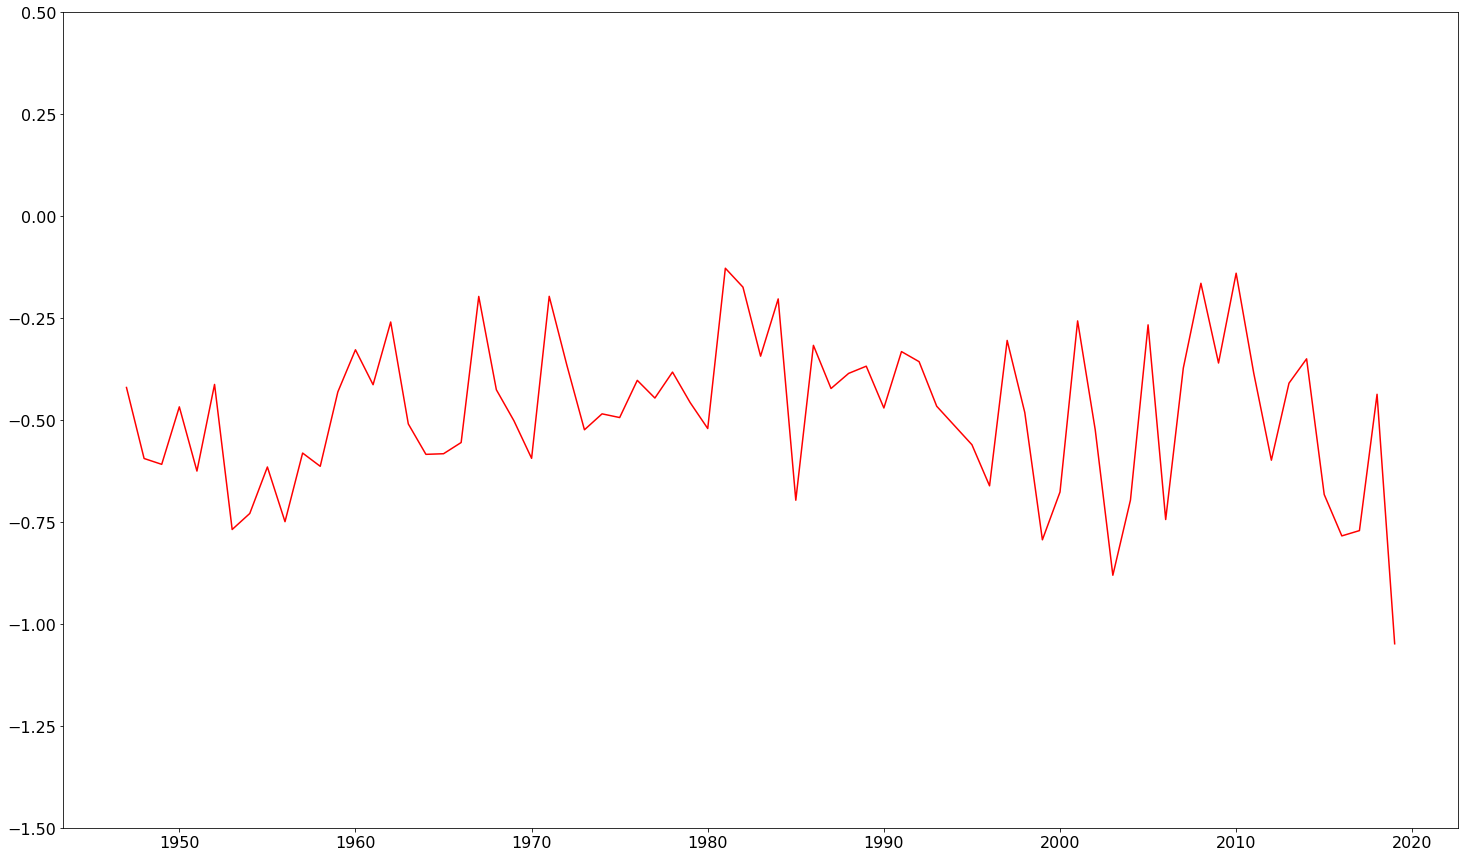

In [17]:
w = list(W_mean_ERA)
l = list(L_mean_ERA)

# remove the data for the year 1994 from the loss tuple because of the strike resulting in no postseason
l.pop(48)

diff = []
for i in range(len(l)):
    diff.append(w[i] - l[i])
    
fig, ax = plt.subplots(figsize=(25, 15))
plt.plot(list(chain(range(1947, 1994), range(1995, 2020))), diff, color='red')
plt.xticks(size=16)
plt.yticks(size=16)
plt.ylim(-1.5, .5)

The line plot shows that the high placing teams' ERA are generally any way between .25 and .75 runs lower than the lower placing teams', with some outliers on either end. Now that we have an understanding of some trends in the data we can move on to model creation. 


# Model Creation

## Trying to predict wins

Now we will move on to doing something with this data! First we will create a linear regression model that predicts the amount of wins a team will have based on their team on base percentage. 

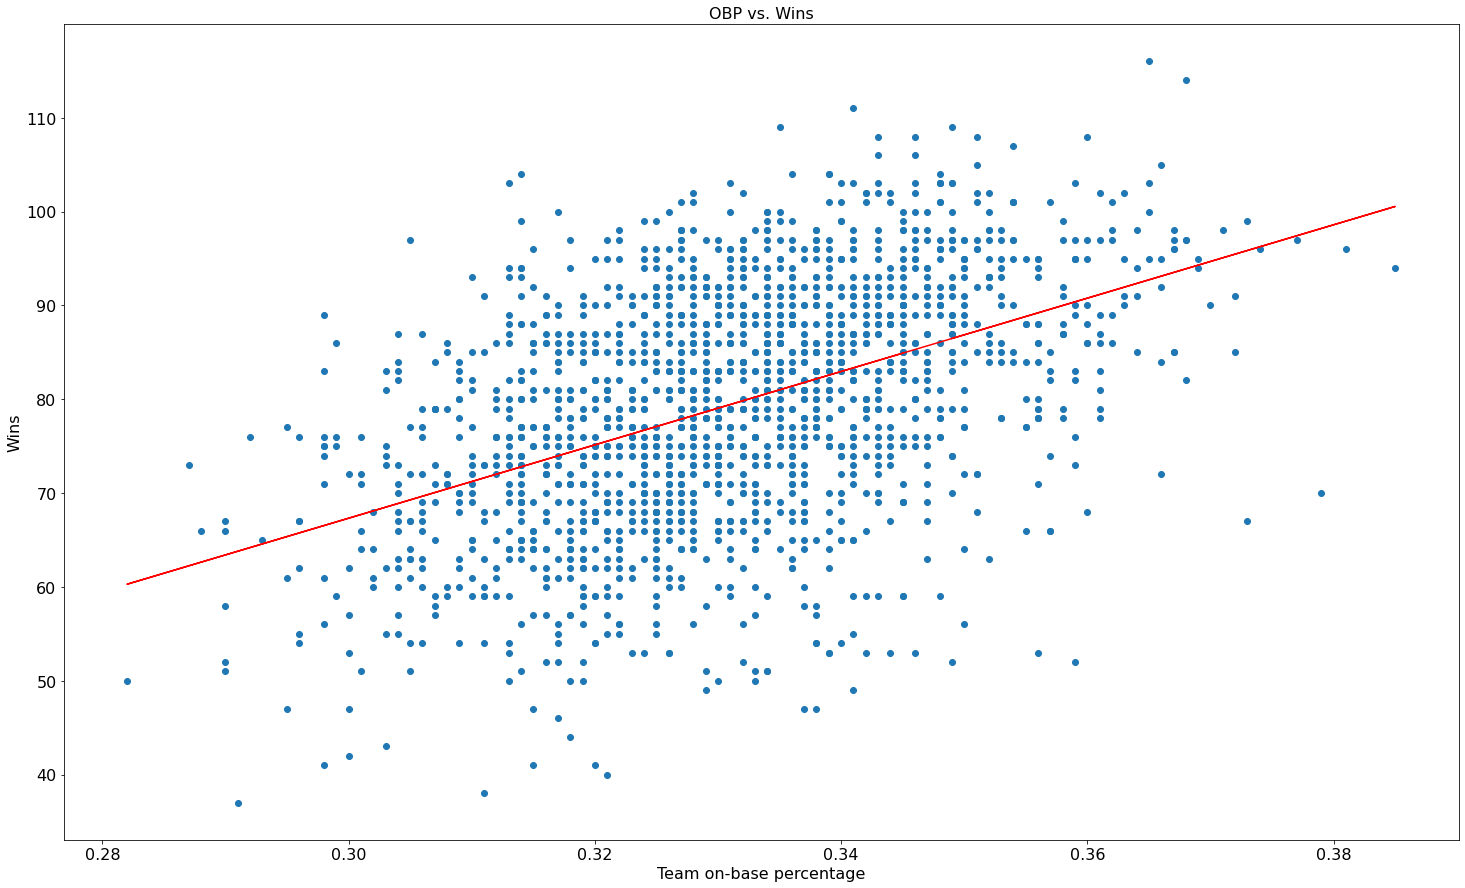

In [18]:
x = batting.team_OBP.values
x = x.reshape(len(batting.index), 1)

y = batting.W.values
y = y.reshape(len(batting.index), 1)

OBP_model = LinearRegression().fit(x, y)

fig, ax = plt.subplots(figsize=(25, 15))
plt.scatter(batting.team_OBP, batting.W)
plt.xlabel("Team on-base percentage", size=16)
plt.ylabel("Wins", size=16)
plt.title("OBP vs. Wins", size=16)
plt.xticks(size=16)
plt.yticks(size=16)

plt.plot(x, OBP_model.predict(x), color='red')

In [19]:
print("OBP Model Accuracy:", OBP_model.score(x, y))

OBP Model Accuracy: 0.21907775652646833


As we can see, this model is not very accurate (predicted points in red). This does make sense though, considering the graph of the data it is attempting to model has very spread out data points. To try to improve this, we will create another linear model, but this time based on more statistics than just OBP. 

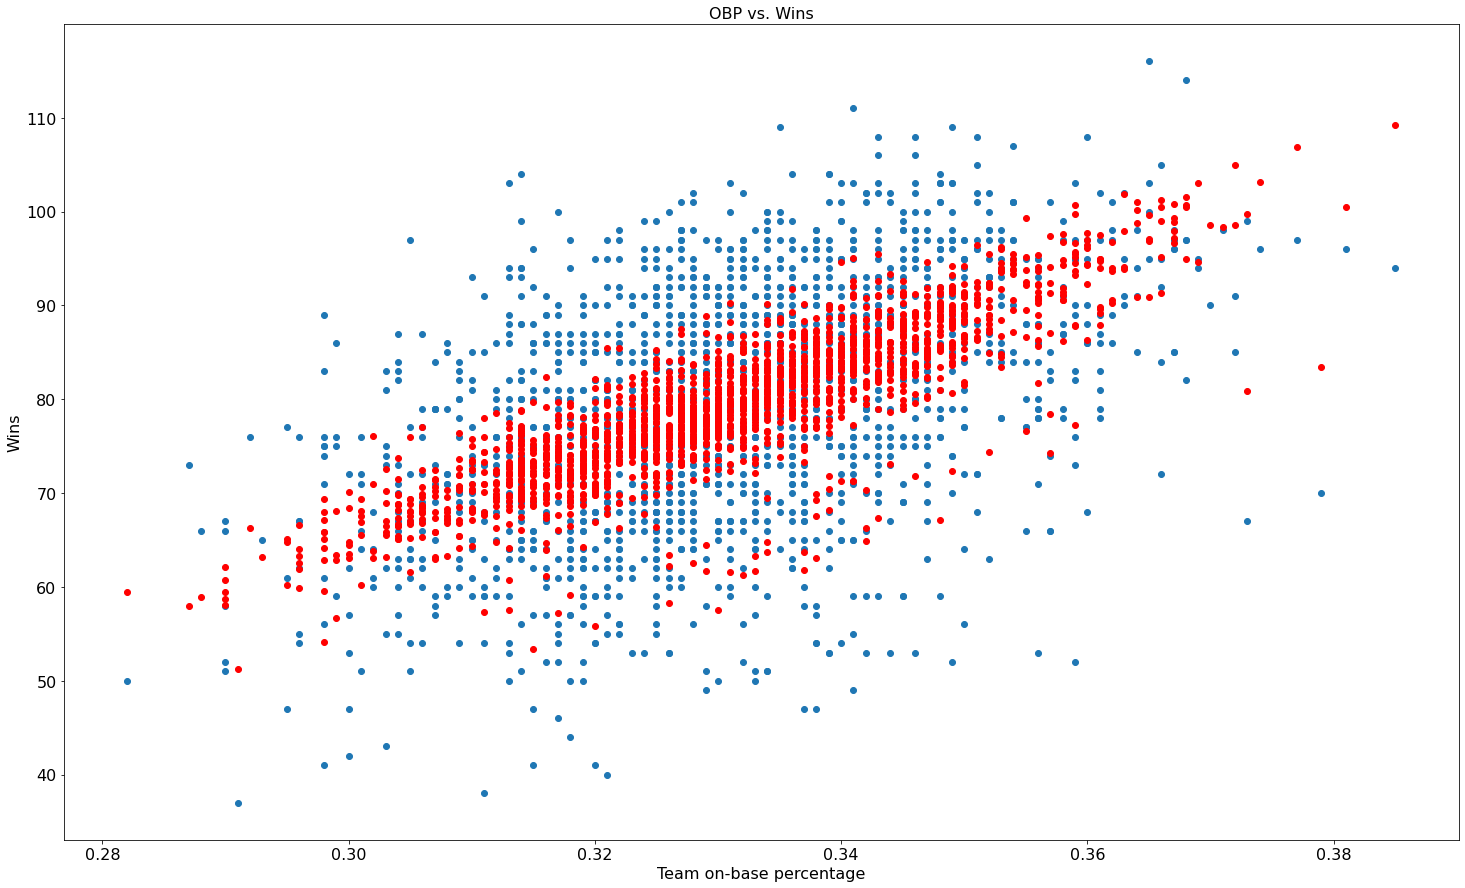

In [20]:
x1 = batting[['HR', 'RBI', 'BB', 'K', 'team_avg', 'team_OBP']].values

multi_model = LinearRegression(fit_intercept=False).fit(x1, y)

fig, ax = plt.subplots(figsize=(25, 15))
plt.scatter(batting.team_OBP, batting.W)
plt.xlabel("Team on-base percentage", size=16)
plt.ylabel("Wins", size=16)
plt.title("OBP vs. Wins", size=16)
plt.xticks(size=16)
plt.yticks(size=16)

plt.scatter(x, multi_model.predict(x1), color='red')

In [21]:
print("Multi Feature Model Accuracy :", multi_model.score(x1, y))

Multi Feature Model Accuracy : 0.3686000964277488


Once again we can see that the linear model fails to be acceptably accurate in predicting team's win total based on home runs, runs batted in, walks, strikeouts, team batting average, and team OBP. However it is markedly better than the single factor linear model before it. 

Another observation I made here is that the predicted values are much more clustered than the real values. Baseball has traditionally been regarded as a game in which chance and luck can play huge factors, and that seems to show itself here, leading to a large range of values. 

Next we will plot the residuals (the difference between the real and predicted values) versus fitted values of the model. 

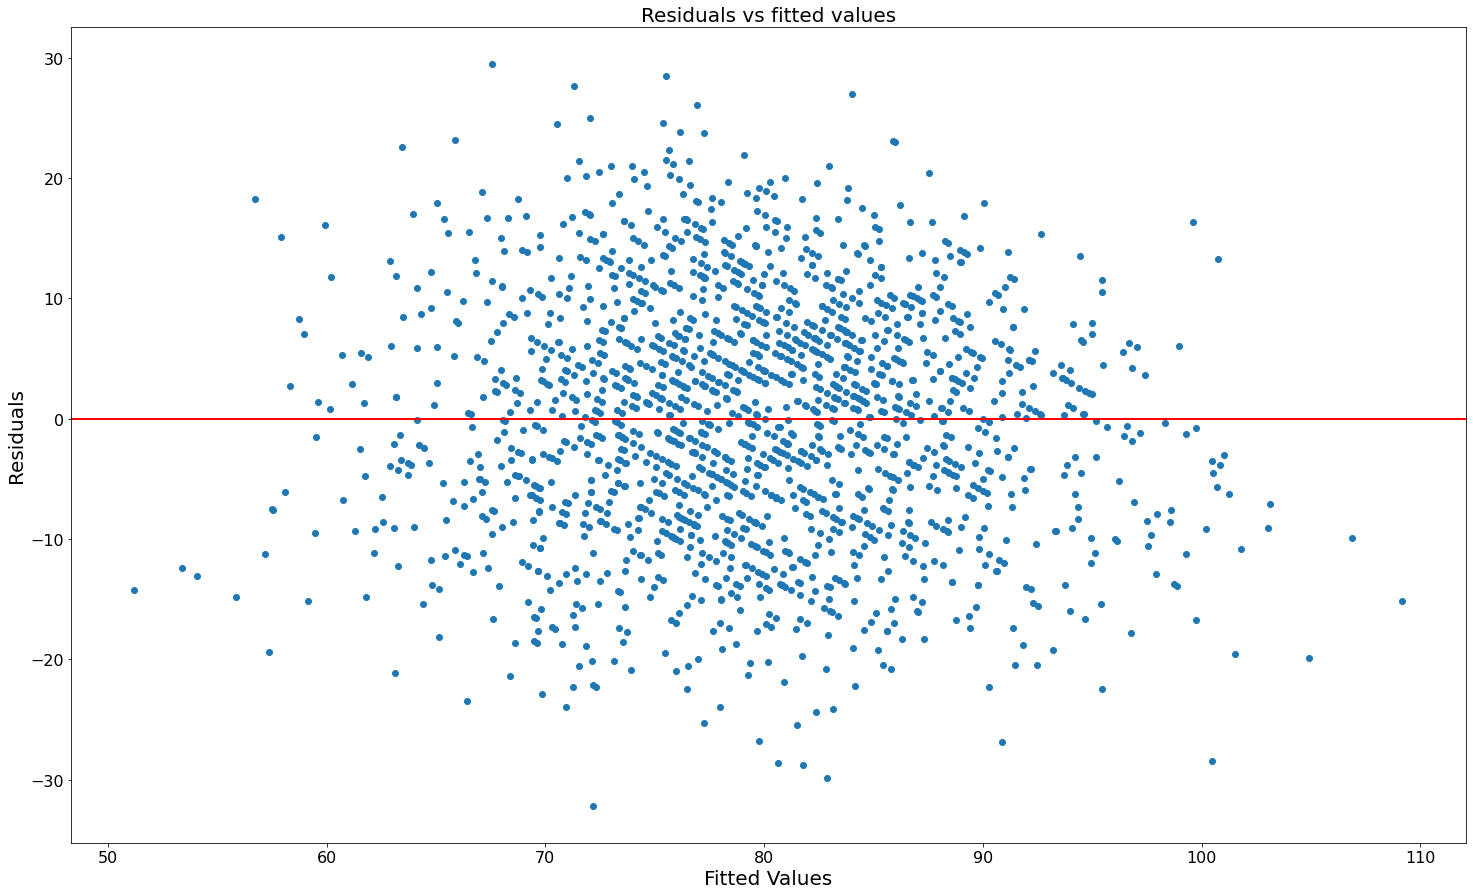

In [22]:
mm_resids = (y - multi_model.predict(x1))

fig, ax = plt.subplots(figsize=(25, 15))
plt.scatter(multi_model.predict(x1), mm_resids)
plt.ylabel('Residuals', size=20);
plt.xlabel('Fitted Values', size=20);
plt.title("Residuals vs fitted values", size=20);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.axhline(y=0, ls='-', lw=2, color='red')

This plot does not reveal any discernable pattern between the residuals and the fitted values, suggesting that the model does not have any systematic errors in it's estimations. This also points to a linear model being a decent choice for modeling this data. The plot also reveals that there is not a huge amount of large outliers. 

## Predicting Success

Now we are going to move on to modeling success of a team based on batting and pitching numbers. First we will fit a logistic regression model based on homeruns, runs batted in, walks, strikeouts, team batting average, and team on base percentage. Here we will define success as finishing in the top two in a team's division, which is stored in the teamRank column of the dataframe as a boolean. A logistic regression classifier does just that, it will attempt to classify a set of input data (in this case a team's statistics) as one of two classes in this case (top 2 in division, or not).

Since the wildcard and divisional rounds of the playoffs did not exist for some of the years this data covers, we are going to consider this version of "success" for this project as opposed to looking at success *in* the postseason. Success in the postseason will also be *much* harder to model as it is a much smaller sample size of teams who make it into the postseason, and an even smaller sample size of teams that won thier League Championship (Series or outright before that round of the postseason was introduced) and/or the World Series. 

In [23]:
log_x = batting[['HR', 'RBI', 'BB', 'K', 'team_avg', 'team_OBP']].values
#log_x = log_x.reshape(len(batting.index), 1)

log_y = batting['teamRank'].values
#log_y = log_y.reshape(len(batting.index), 1)

logmodel = LogisticRegressionCV(cv=10).fit(log_x, log_y)

print("Batting Logistic Regression Model Accuracy:", logmodel.score(log_x, log_y))

Batting Logistic Regression Model Accuracy: 0.7204481792717087


The above printed value is the accuracy of our Logistic Regression model. We can see that the logistic regression classifier was more successful in predicting than either of our previous linear models, but was still not super accurate. We should take this accuracy number with a grain of salt however, since the large majority of the values the model is trying to predict *are* false, so it would be very easy for the model to "luck" into a good set of predictions. 

Now we will fit the same type of model on the pitching data.|

In [24]:
pitching_log_x = pitching[['H', 'ER', 'HR', 'BB', 'K', 'BAA', 'ERA', 'WHIP']].values
#log_x = log_x.reshape(len(batting.index), 1)

pitching_log_y = pitching['teamRank'].values
#log_y = log_y.reshape(len(batting.index), 1)

pitching_logmodel = LogisticRegressionCV(cv=10).fit(pitching_log_x, pitching_log_y)

print("Pitching Logistic Regression Model Accuracy:", pitching_logmodel.score(pitching_log_x, pitching_log_y))

Pitching Logistic Regression Model Accuracy: 0.7146067415730337


As the above numbers show, a logistic regression classifier based on pitching numbers was as innacurate as the batting model.

With both of these models being disappointing, let's try something else: creating a model based on BOTH pitching and batting data. 

In the cell below, we create a new dataframe that contains the data from both the batting and dataframes that we used to create the above models. Prior to that we have to rename some of hte columns in the pitching dataframe that we want to keep separate, because they have duplicate names. Following that cell, we fit a logistic regression classifier to this combined data.

In [25]:
temp = pitching.rename(columns={"H" : "pitching_H", "HR" : "pitching_HR", "BB" : "pitching_BB", "K" : "pitching_K",})
combined = batting.merge(temp, on=['yearID', 'team_ID'])

combined.tail()

,yearID,teamID_x,team_ID,R,HR,RBI,BB,K,IBB,HBP,...,pitching_BB,pitching_K,BAA,GIDP,ERA,WHIP,ID_y,teamRank_y,LgWin_y,WSWin_y
1775,2019,SLN,2921,764,210,714.0,561,1420.0,15.0,76.0,...,545,1399,0.238478,139.0,3.82,1.27,2921,True,False,False
1776,2019,TBA,2922,769,217,730.0,542,1493.0,20.0,73.0,...,453,1621,0.242667,107.0,3.67,1.17,2922,True,False,False
1777,2019,TEX,2923,810,223,765.0,534,1578.0,18.0,67.0,...,583,1379,0.286917,131.0,5.09,1.46,2923,False,False,False
1778,2019,TOR,2924,726,247,697.0,509,1514.0,10.0,45.0,...,604,1332,0.279256,111.0,4.79,1.43,2924,False,False,False
1779,2019,WAS,2925,873,231,824.0,584,1308.0,33.0,81.0,...,517,1511,0.323774,98.0,4.28,1.29,2925,True,True,True


In [26]:
combined_x = combined[['HR', 'RBI', 'BB', 'K', 'team_avg', 'team_OBP', 'pitching_H', 'ER', 'pitching_HR', 'pitching_K', 'pitching_BB', 'BAA', 'ERA', 'WHIP']].values
#log_x = log_x.reshape(len(batting.index), 1)

combined_y = combined['teamRank_y'].values
#log_y = log_y.reshape(len(batting.index), 1)

combined_logmodel = LogisticRegression().fit(combined_x, combined_y);

In [27]:
combined_logmodel.score(combined_x, combined_y)

0.8471910112359551

Wow! This linear regression classifier is *far* more accurate than either previous log model. The model's accuracy, reported by the score function of sklearn's logistic regression classifier method, was nearly 85%. Now that we've seen how accurate this logistic regression model was, let's create a linear regression model based on the same input data, but that models the number of wins a team got:

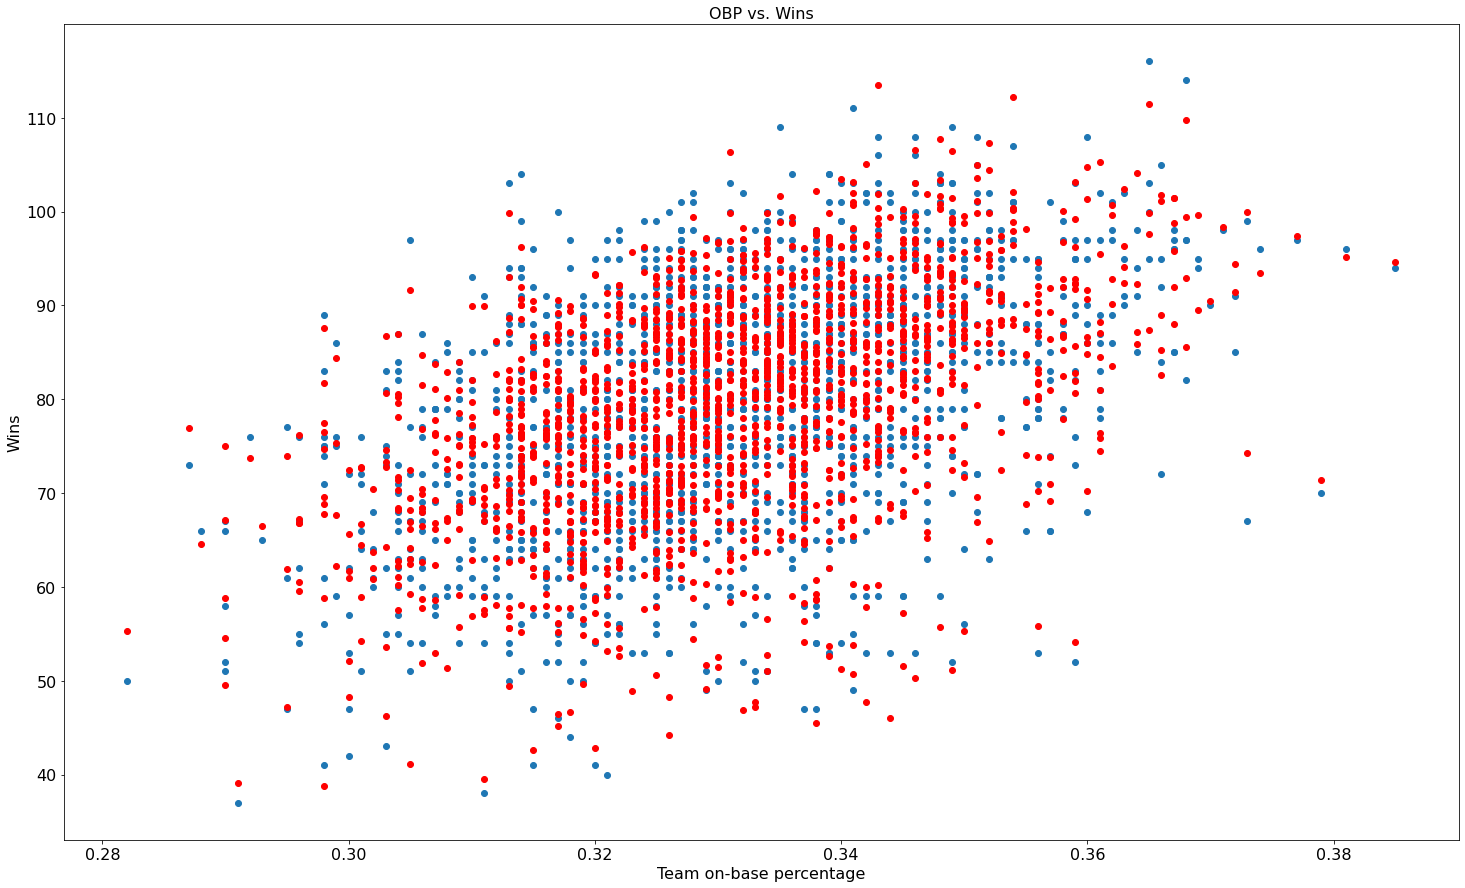

In [28]:
combined_linearmodel = LinearRegression().fit(combined_x, combined.W_y)

fig, ax = plt.subplots(figsize=(25, 15))
plt.scatter(batting.team_OBP, batting.W)
plt.xlabel("Team on-base percentage", size=16)
plt.ylabel("Wins", size=16)
plt.title("OBP vs. Wins", size=16)
plt.xticks(size=16)
plt.yticks(size=16)

plt.scatter(combined.team_OBP, combined_linearmodel.predict(combined_x), color='red')

Much like the log classifier above, we can see that the batting and pitching model is *much* more accurate and make much better predictions than any of the prior models. 

In [29]:
print(combined_linearmodel.score(combined_x, combined.W_y))

0.8920923652272907


The score reported by the estimator reflects the accuracy we see in the plot. Next we create another Residuals vs. Fitted Values plot, but for the combined linear model this time. 

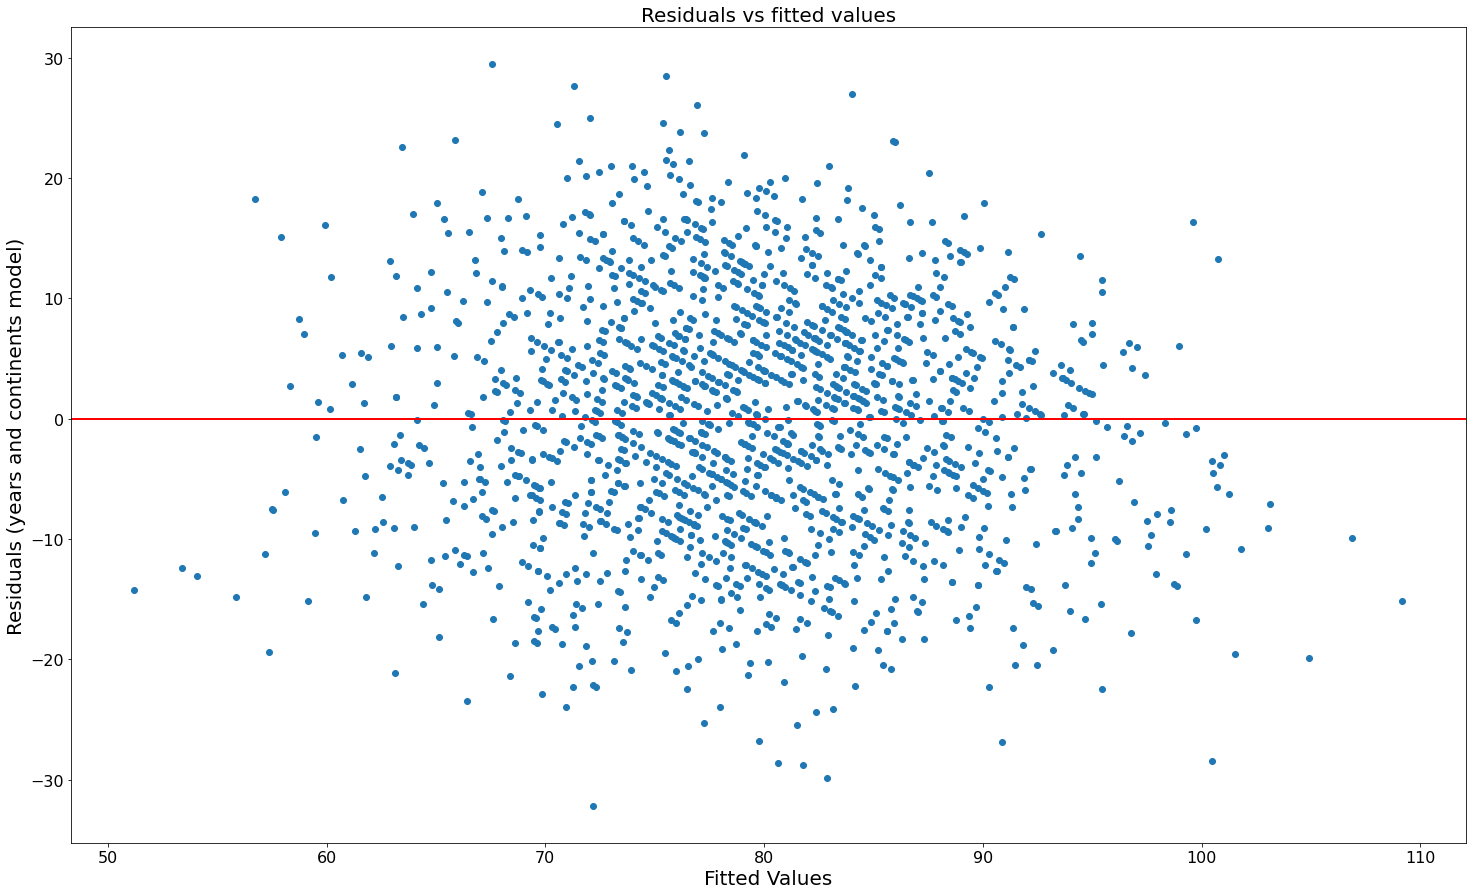

In [30]:
combined_resids = (combined.W_y - combined_linearmodel.predict(combined_x))

fig, ax = plt.subplots(figsize=(25, 15))
plt.scatter(multi_model.predict(x1), mm_resids)
plt.ylabel('Residuals (years and continents model)', size=20);
plt.xlabel('Fitted Values', size=20);
plt.title("Residuals vs fitted values", size=20);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.axhline(y=0, ls='-', lw=2, color='red')

This plot shows no noticeable patterns or clustering in its points, suggesting that our linear regression model was a good choice to model this data and does not have any systematic errors.

## Testing our model on the 2020 season's data

Now that we have a model that was accurate on the 1947-2019 data, lets apply our model to the 2020 season's data. The 2020 season data was taken from [Baseball Reference](https://www.baseball-reference.com/leagues/MLB/2020.shtml), an *excellent* resource for baseball statistics. 

One problem we run into with the 2020 season's data is that the 2020 season was short, with the league only playing 60 (or less in some cases) games due to the scheduled start of the season being delayed due to the 'beginning' of the COVID-19 pandemic in March, which interrupted Spring Training. To get a *very* rough estimate of counting statistics like hit or homerun totals, we can extrapolate them as if they were from a 162 game season by multiplying them by 2.7 (60 * 2.7 = 162). This way they are more compatible with our model. We are going to leave rate statistics like batting average, OBP, and ERA they way they are, since they are rate statistics and do not need scaling.

Another issue is that we will now get win totals that are being predicted as if a full season was played. To get a statistic concerning wins that is comparable across different length seasons we can use win percentage, which is calculated by: 
<h1><center>$\textrm{win_pct} = \frac{\textrm{wins}}{\textrm{games played}}$</center></h1>

Conveniently, the data we are using from BBRef already has the real life win percentage calculated for us. 

First we must obtain the data, which I downloaded from BBRef in comma separated value (csv) format, which pandas supports. Starting with the pitching data from the 2020 season, we need to calculate batting average against as it is not given. For this data we are using: <h1><center>$\textrm{BAA} = \frac{\textrm{H}}{\textrm{batters faced} - \textrm{BB } - \textrm{ IBB } - \textrm{ HBP}}$</center></h1>
which is imperfect since this data does not include sacrifice hits, sacrifice flies, or catcher's interference data, which [this formula](https://en.wikipedia.org/wiki/Batting_average_against) includes. We will just use and rename the loss column in this data to store BAA since we will not need it later at all. 

In [31]:
# https://www.baseball-reference.com/leagues/MLB/2020.shtml
pitching_2020 = pd.read_csv('pitching2020.csv')

for row in pitching_2020.iterrows():
    pitching_2020.at[row[0], 'L'] = pitching_2020.at[row[0], 'H']\
                                        / (pitching_2020.at[row[0], 'BF'] - pitching_2020.at[row[0], 'BB']\
                                          - pitching_2020.at[row[0], 'HBP'] - pitching_2020.at[row[0], 'IBB'])

After we calculate the BAA for each team in 2020, we can drop the numerous columns we will not be using, and then rename the loss column as mentioned above, as well as renaming columns that will have naming collisions with columns in the batting table. We also drop the last three rows, which contain league averages and totals.

In [32]:
pitching_2020.drop([30, 31, 32], inplace=True)
pitching_2020.drop(['#P','PAge', 'RA/G', 'G', 'GS', 'GF', 'CG', 'tSho', 'cSho', 'SV', \
                    'BK', 'WP', 'BF', 'ERA+', 'H9', 'HR9', 'BB9', 'SO9', 'SO/W', 'LOB'],\
                   axis=1, inplace=True)

pitching_2020.rename(columns={"L" : "BAA", "W-L%" : "real_win%", "H" : "pitching_H",  "ER" : "pitching_ER", "R" : "pitching_R", "HR" : "pitching_HR", "BB" : "pitching_BB", "SO" : "pitching_SO"}, inplace=True)

Now that we have 2020's pitching data, we can get the batting data, which does not require any extra calculations, and drop columns that will not be useful to us, as well as the last two rows which contain totals and averages for the league.

In [33]:
batting_2020 = pd.read_csv('batting2020.csv')
batting_2020.drop([30, 31], inplace=True)
batting_2020.drop(['SB', 'CS', 'SLG', 'OPS', 'OPS+', 'TB', 'HBP', 'SH', 'LOB'], axis=1, inplace=True)

Now that we have pitching and batting data, we need to combine them into one dataframe which we can feed to our model. After we do this we can apply our rough extrapolation to the counting stats that the model uses to predict wins. 

In [34]:
total_2020 = pd.concat([pitching_2020, batting_2020], axis=1)

#60 * 2.7 = 162, so we can get a VERY ROUGH estimate of these numbers across a 162 game season
# by just multiplying counting stats by this constant, this is necessary because the model was
# trained on 162 game seasons
for row in total_2020.iterrows(): 
    total_2020.at[row[0], 'HR'] = 2.7 * total_2020.at[row[0], 'HR']
    total_2020.at[row[0], 'RBI'] = 2.7 * total_2020.at[row[0], 'RBI']
    total_2020.at[row[0], 'BB'] = 2.7 * total_2020.at[row[0], 'BB']
    total_2020.at[row[0], 'SO'] = 2.7 * total_2020.at[row[0], 'SO']
    total_2020.at[row[0], 'pitching_H'] = 2.7 * total_2020.at[row[0], 'pitching_H']
    total_2020.at[row[0], 'pitching_ER'] = 2.7 * total_2020.at[row[0], 'pitching_ER']
    total_2020.at[row[0], 'pitching_HR'] = 2.7 * total_2020.at[row[0], 'pitching_HR']
    total_2020.at[row[0], 'pitching_SO'] = 2.7 * total_2020.at[row[0], 'pitching_SO']
    total_2020.at[row[0], 'pitching_BB'] = 2.7 * total_2020.at[row[0], 'pitching_BB']

total_2020.head()

,Tm,W,BAA,real_win%,ERA,IP,pitching_H,pitching_R,pitching_ER,pitching_HR,...,3B,HR,RBI,BB,SO,BA,OBP,GDP,SF,IBB
0,ARI,25.0,0.252874,0.417,4.84,518.1,1366.2,295.0,753.3,251.1,...,12,156.6,688.5,488.7,1244.7,0.241,0.312,37,23,5
1,ATL,35.0,0.245771,0.583,4.41,524.1,1333.8,288.0,693.9,186.3,...,3,278.1,912.6,645.3,1547.1,0.268,0.349,39,7,13
2,BAL,25.0,0.242319,0.417,4.51,518.2,1320.3,294.0,702.0,213.3,...,7,207.9,712.8,442.8,1387.8,0.258,0.321,32,10,5
3,BOS,24.0,0.279258,0.400,5.58,524.0,1584.9,351.0,877.5,264.6,...,7,218.7,750.6,504.9,1471.5,0.265,0.330,51,9,8
4,CHC,34.0,0.231638,0.567,3.99,518.1,1217.7,240.0,621.0,199.8,...,8,199.8,669.6,618.3,1533.6,0.220,0.318,42,13,9


Now that we have data that was roughly extrapolated for a full length season, we can create our input vector, and see how the model fairs. We need the predicted wins to be represented as win percentage to be comparable across the 60 and 162 game seasons, so we iterate through each row and calculate that as well. This formula is the same as above: wins over games played. 

In [35]:
input_2020 = total_2020[['HR', 'RBI', 'BB', 'SO', 'BA', 'OBP', 'pitching_H', 'pitching_ER', 'pitching_HR', 'pitching_SO', 'pitching_BB', 'BAA', 'ERA', 'WHIP']].values

total_2020.insert(3, 'predicted_win%', 0.0)
total_2020['predicted_win%'] = combined_linearmodel.predict(input_2020)

for row in total_2020.iterrows(): 
    total_2020.at[row[0], 'predicted_win%'] = round(total_2020.at[row[0], 'predicted_win%']/162, 3)

total_2020.head()

,Tm,W,BAA,predicted_win%,real_win%,ERA,IP,pitching_H,pitching_R,pitching_ER,...,3B,HR,RBI,BB,SO,BA,OBP,GDP,SF,IBB
0,ARI,25.0,0.252874,0.419,0.417,4.84,518.1,1366.2,295.0,753.3,...,12,156.6,688.5,488.7,1244.7,0.241,0.312,37,23,5
1,ATL,35.0,0.245771,0.603,0.583,4.41,524.1,1333.8,288.0,693.9,...,3,278.1,912.6,645.3,1547.1,0.268,0.349,39,7,13
2,BAL,25.0,0.242319,0.477,0.417,4.51,518.2,1320.3,294.0,702.0,...,7,207.9,712.8,442.8,1387.8,0.258,0.321,32,10,5
3,BOS,24.0,0.279258,0.382,0.400,5.58,524.0,1584.9,351.0,877.5,...,7,218.7,750.6,504.9,1471.5,0.265,0.330,51,9,8
4,CHC,34.0,0.231638,0.508,0.567,3.99,518.1,1217.7,240.0,621.0,...,8,199.8,669.6,618.3,1533.6,0.220,0.318,42,13,9


Now that we have both the true and predicted win percentages, we can plot them and examine how well the model did. 

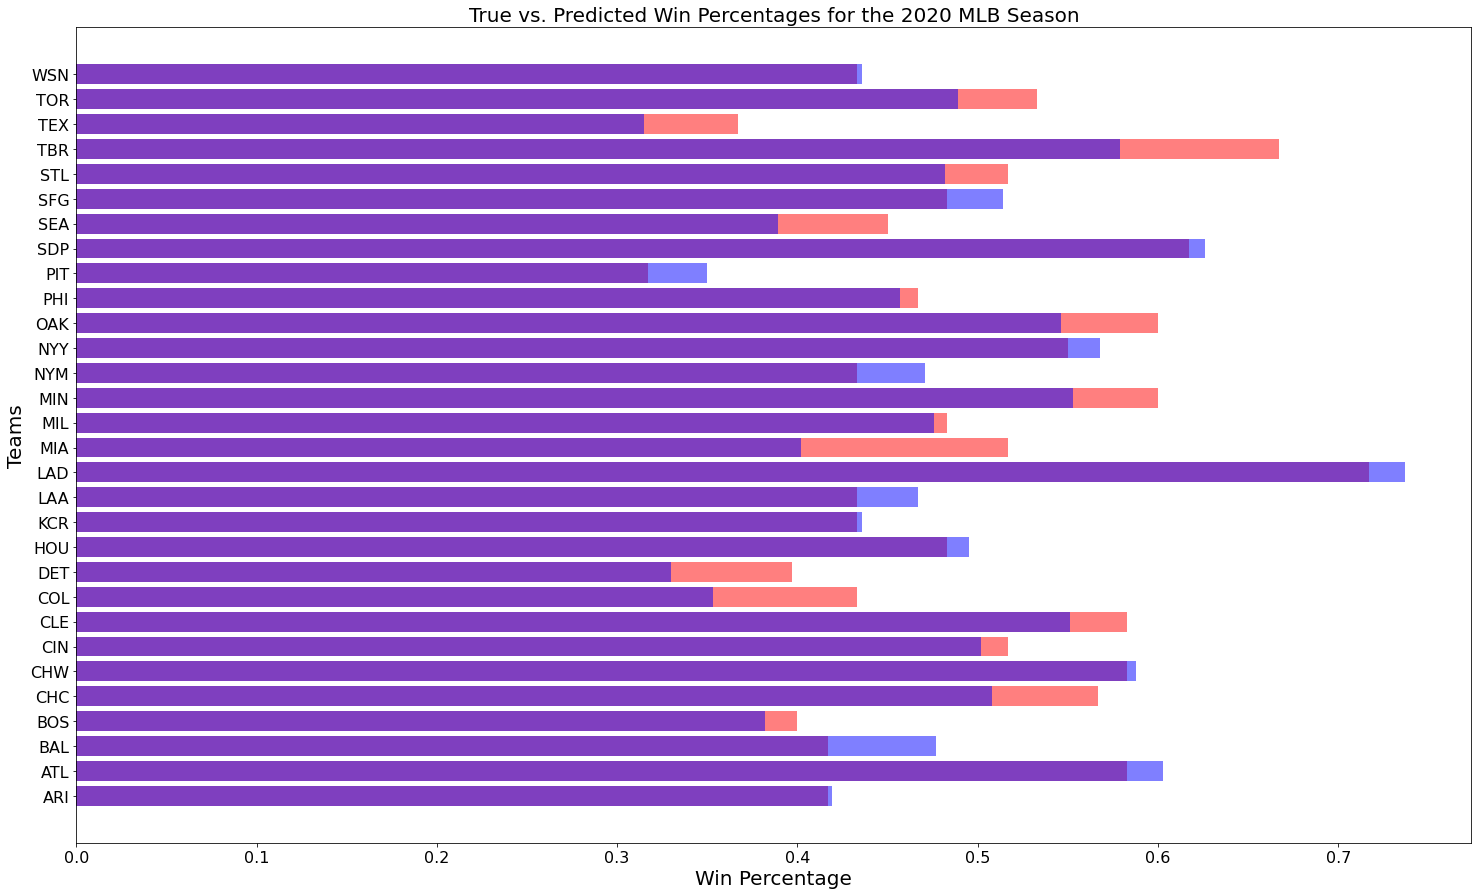

In [36]:
fig, ax = plt.subplots(figsize=(25, 15))

# from https://stackoverflow.com/questions/7961363/removing-duplicates-in-the-lists
teams = list(dict.fromkeys(total_2020.Tm.values.flatten()))
real_win_pct = total_2020['real_win%'].values
pred_win_pct = total_2020['predicted_win%'].values
    
plt.barh(teams, real_win_pct, alpha=0.5, color='red')
plt.barh(teams, pred_win_pct, alpha=0.5, color='blue')
plt.ylabel('Teams', size=20);
plt.xlabel('Win Percentage', size=20);
plt.title("True vs. Predicted Win Percentages for the 2020 MLB Season", size=20);
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

Each team's win percentage and predicted win percentage are plotted in the above bar chart. The true percentages are in red, and the predicted percentages are in blue. On bars where the top section is red, this means that the true win percentage of the team was greater than the predicted win percentage. Oppositely, bars where the top section is blue mean that the team's true win percentage was lower than the predicted win percentage. Bars with large blue or red sections at the top are where the model was least accurate, whereas bars like ARI and WSN where the non-purple section is almost too small to see are where the model was most accurate.

Of course, the data we fed the model was not perfectly accurate so we cannot expect perfect results. For example, the Los Angeles Dodgers' real win percentage of .717 would have them winning 116 games over a full and normal, season, which would tie the all time record. This shows how unrealistic model's prediction of a .737 win percentage is (equates to 119 wins). This prediction error is due to both the unavoidable imperfection of the model, as well as how we applied a constant scalar of 2.7 to every counting stat to extrapolate those numbers over a full season to increase compatibilty with our model. 

## Results 

Both the linear and logistic regression models that were based on both pitching and batting data proved to be the most accurate. This does make a lot of sense, since the success of an MLB team depends on a lot more factors than just batting average, OBP, ERA, or WHIP. A team with one player with an insane OBP could bring the team average up a lot and lead the one-factor models to very incorrectly predict that team's success (for example, consider the [2015 Washington Nationals](https://www.baseball-reference.com/teams/WSN/2015.shtml), where [Bryce Harper](https://www.baseball-reference.com/players/h/harpebr03.shtml) had a .460 (!!!) on base percentage, but the next highest OBP on the team was .375).



# Conclusion

When we created linear and logistic regression models based on many batting and pitching numbers, we were able to predict a team's win total and if they finished top-two in their division with 89% and 85% accuracy, respectively. These models are of course imperfect, but they give insight into how helpful and important data science can be in the baseball world. 

If you would like to read more about the influence of statistics in baseball, a great jumping off point would the the Moneyball movie and book mentioned in the introduction. Below I provide some links to sites like the Society for American Baseball Research (SABR) and Baseball Reference, as well as the MLB.com page on ZiPS projections for further learning. 

- [Society for American Baseball Research (SABR)](https://sabr.org/sabermetrics)
- [Baseball Reference](https://www.baseball-reference.com/)
- [Fangraphs](https://www.fangraphs.com/)
- [ZiPS Projections](http://m.mlb.com/glossary/projection-systems/szymborski-projection-system)